<a href="https://colab.research.google.com/github/simranbajwa13/About-me/blob/main/ECS708P_Simranjeet_200740827.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECS708P mini-project submission

The mini-project consists of two components:


1.   **Basic solution** [6 marks]: Using the MLEnd dataset, build a model that predicts the intonation of a short audio segment.
2.   **Advanced solution** [10 marks]: There are two options. (i) Formulate a machine learning problem that can be attempted using the MLEnd dataset and build a solution model (e.g. identify a numeral in a short sequence). (ii) Create a product that uses the functionality provided by a model trained on the MLEnd dataset (e.g. identify a number based on the identification of individual numerals).  

The submission will consist of a single Jupyter notebook for both basic and advanced solution. The uploaded notebook should contain: 

*   **Text cells**, describing concisely each step and results.
*   **Code cells**, implementing each step.
*   **Output cells**, i.e. the output from each code cell.

and should have **two separate sections** for the basic and the advanced solutions.

What should you include in your notebook?

*   Title, student name, student ID.
*   Brief summary.
*   Dataset preparation.
*   Dataset visualisation.
*   Preprocessing.
*   Model(s) description.
*   Training and validation tasks.
*   Performance evaluation (accuracy, confusion matrix, ROC curve, etc).
*   Conclusions.


How will we evaluate your submission?

*   Conciseness in your writing (10%).
*   Correctness in your methodology (30%).
*   Correctness in your analysis and conclusions (30%).
*   Completeness (10%).
*   Originality (10%).
*   Efforts to try something new (10%).

Suggestion: Why don't you use **GitHub** to manage your project? GitHub can be used as a presentation card that showcases what you have done and gives evidence of your data science skills, knowledge and experience. 


# Mini Project 


**Name** : Simranjeet kaur

**Student ID**: 200740827

#1 Basic Solution

# Brief summary

The Problem here is to identify the intonation of a short audio segment. As a part of the solution we will train different models over the dataset and use cross validation approach to evaluate the best model for the dataset.

As the first step of this basic solution, make a connection to google drive and import all the required libraries.

In [ ]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

#from IPython.display import Audio
import IPython.display as ipd
from tqdm import tqdm
import librosa
drive.mount('/content/drive')

Mounted at /content/drive


Run the following cell to check for the trainingMLEnd.csv file

In [ ]:
path = '/content/drive/MyDrive/Data/MLEnd'
os.listdir(path)

['trainingMLEnd.csv', 'training', 'training.zip']

#Data Preperation

As a part of data preperation this section includes downloading the data for our solution. The following function is defined, which will be used for downloading the file to a chosen loaction.

In [ ]:
def download_url(url, save_path):
    with urllib.request.urlopen(url) as dl_file:
        with open(save_path, 'wb') as out_file:
            out_file.write(dl_file.read())

The next step is to download the zip file into the folder, that was created previously in the drive and then finnaly unzipping the file that is downloaded.

In [ ]:
url  = "https://collect.qmul.ac.uk/down?t=4LO0R0TSLPGGHJPC/45O137K56GGVDFUT9AH4ST"
save_path = '/content/drive/MyDrive/Data/MLEnd/training.zip'
download_url(url, save_path)

In [ ]:
directory_to_extract_to = '/content/drive/MyDrive/Data/MLEnd/training/'
with zipfile.ZipFile(save_path, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

The next cell shows the number of audio files in the dataset.

In [ ]:
files = glob.glob('/content/drive/MyDrive/Data/MLEnd/training/*/*.wav')
len(files)

20000

In the next step the contents of the CSV file are loaded into a Panda dataframe.

In [ ]:
labels = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/trainingMLEnd.csv')
labels

,File ID,digit_label,participant,intonation
0,0000000.wav,4,S73,question
1,0000001.wav,2,S88,excited
2,0000002.wav,70,S5,neutral
3,0000003.wav,2,S85,bored
4,0000004.wav,4,S30,excited
...,...,...,...,...
19995,0019995.wav,90,S163,excited
19996,0019996.wav,10,S99,question
19997,0019997.wav,90,S46,question
19998,0019998.wav,19,S13,neutral


After loading the data, the next step is to extract the features of the audio file dataset and use them as predictors. For that purpose in the next cell a function is defined to extract the pitch of the audio signal.

In [ ]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

The next step involves extracting four featues of the audio files which will be used as predictors. The problem is now to indentify the intonation of given audio segment, for which a function is defined  that takes a number of files and creates a NumPy array containing the 4 audio features used as predictors (X) and their labels (y).  

In [ ]:
def getXy(files,labels_file,scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    yi = list(labels_file[labels_file['File ID']==fileID]['intonation'])[0]
    
    fs = None # if None, fs would be 22050
    x, fs = librosa.load(file,sr=fs)
    if scale_audio: x = x/np.max(np.abs(x))
    f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
    power = np.sum(x**2)/len(x)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    voiced_fr = np.mean(voiced_flag)

    xi = [power,pitch_mean,pitch_std,voiced_fr]
    X.append(xi)
    y.append(yi)
  return np.array(X),np.array(y)

For this solution 500 audio files will be used out of 20k

In [ ]:
X,y = getXy(files[:500],labels_file=labels,scale_audio=True, onlySingleDigit=True)


100%|██████████| 500/500 [05:37<00:00,  1.48it/s]


In [ ]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)
print('The labels vector is', y)

The shape of X is (500, 4)
The shape of y is (500,)
The labels vector is ['question' 'neutral' 'bored' 'excited' 'excited' 'bored' 'excited'
 'question' 'excited' 'question' 'question' 'neutral' 'neutral' 'bored'
 'excited' 'question' 'bored' 'excited' 'excited' 'bored' 'bored'
 'question' 'bored' 'excited' 'question' 'neutral' 'bored' 'question'
 'bored' 'bored' 'question' 'question' 'bored' 'excited' 'neutral'
 'question' 'question' 'bored' 'excited' 'question' 'excited' 'excited'
 'neutral' 'neutral' 'question' 'excited' 'bored' 'neutral' 'neutral'
 'bored' 'neutral' 'neutral' 'neutral' 'bored' 'excited' 'bored' 'bored'
 'question' 'neutral' 'question' 'neutral' 'bored' 'neutral' 'bored'
 'bored' 'bored' 'bored' 'excited' 'excited' 'question' 'excited'
 'question' 'question' 'excited' 'neutral' 'excited' 'excited' 'question'
 'neutral' 'excited' 'excited' 'question' 'question' 'question' 'excited'
 'excited' 'neutral' 'question' 'neutral' 'neutral' 'bored' 'neutral'
 'neutral' 'ques

# Preprocessing

As a part of preprocessing the dataset all the NaN (Not a number) elements are removed. 

In [ ]:
# If nan sample, remove them
if np.sum(np.isnan(X)):
  idx = np.isnan(X).sum(1)>0
  X = X[~idx]
  y = y[~idx]
print(np.sum(np.isnan(X)))

0


The final preprocessing step is to divide the data into training and validation sets. The train_test_split method, will be used to randomly split the data into training and validation sets. Execute the following cell to do so:

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((350, 4), (150, 4), (350,), (150,))

# Models Description

Once the data has been divided into the training and validation sets, the final step is to train different models on the data and make predictions. The next cell shows the K-Fold Cross validation approach taken up with 8-folds (i.e 8 different groups the dataset is split into) to evaluate each algorithm and find the best fit model for the dataset. The output displays the mean accuracy and standard deviation accuracy of each algorithm and the box plot graph shows the comparison between different algorithms in terms of their performance (accuracy). 

KNN: 0.465758 (0.086577)
RFC: 0.478015 (0.059560)
NB: 0.497984 (0.056674)
SVM: 0.445789 (0.067850)


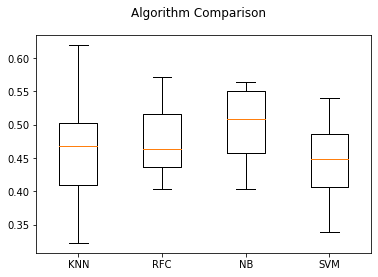

In [ ]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# prepare configuration for cross validation test harnes
# prepare models
models = []

models.append(('KNN', KNeighborsClassifier()))
models.append(('RFC', RandomForestClassifier(n_estimators=5)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(kernel='linear', C=0.01)))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=8)
	cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
 

 # boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()


From the results, it would suggest that both Random forest classifier   and Gaussian Naive Bayes (GaussianNB) analysis are worthy of further study on this problem. Since both have a higher accuracy compared to the other two models, these two models will be further evaluated using a confusion matrix analysis to find the best among them.

# Confusion Matrix

Below is the confusion matrix for the Gaussian Naive Bayes algorithm

In [ ]:
from sklearn.naive_bayes import MultinomialNB # or any other NB model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

nb_classifier = MultinomialNB()

nb_classifier.fit(X_train, y_train)

y_pred = nb_classifier.predict(X_val)

acc_score = accuracy_score(y_val, y_pred)
conf_mat = confusion_matrix(
        y_val, y_pred, labels = ['bored','excited','neutral','question'])

print(acc_score)
print(conf_mat)

0.47
[[21  0  3  1]
 [ 4  7  2 11]
 [18  4  6  1]
 [ 0  6  3 13]]


Below is the confusion matrix for the Random Forest classifier algorithm

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# implementing train-test-split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
rfc = RandomForestClassifier(n_estimators=5)
rfc.fit(X_train,y_train)
rfc_predict = rfc.predict(X_val)
acc_score = accuracy_score(y_val, rfc_predict)
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_val, rfc_predict))
print('\n')
print(acc_score)


=== Confusion Matrix ===
[[13  3 18  1]
 [ 3 21  7  8]
 [ 8 13 14  5]
 [ 0 12  8 16]]


=== Classification Report ===
              precision    recall  f1-score   support

       bored       0.54      0.37      0.44        35
     excited       0.43      0.54      0.48        39
     neutral       0.30      0.35      0.32        40
    question       0.53      0.44      0.48        36

    accuracy                           0.43       150
   macro avg       0.45      0.43      0.43       150
weighted avg       0.45      0.43      0.43       150



0.4266666666666667


From the results of the above cells, Gaussian Naive Bayes model has an accuracy of 0.47 whereas Random Forest classifier model has an accuracy of 0.42

# Conclution

From the above problem solution it can be concluded that best fit model for the given dataset is Gaussian Naive Bayes model with an accuracy of 0.47 which was highest among all the other trained models. The accuracy of this model can be increased if the number of audio files taken under consideration are increased. The accuracy of the solution also drops when the number of features taken into account are altered (i.e if they are reduced). 

# 2 Advanced solution

**Name**: Simranjeet kaur

**Student ID**: 200740827

# Brief summary

The Problem here is to identify if a spoken numeral is a composite number or not. Composite numbers are positive integers that can be formed by multiplying two smaller positive integers. Equivalently, it is a positive integer that has at least one divisor other than 1 and itself. 

As the first step of this Advanced solution, make a connection to google drive and import all the required libraries.

In [ ]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

#from IPython.display import Audio
import IPython.display as ipd
from tqdm import tqdm
import librosa
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Run the following cell to check for the trainingMLEnd.csv file

In [ ]:
path = '/content/drive/MyDrive/Data/MLEnd'
os.listdir(path)

['trainingMLEnd.csv', 'training', 'training.zip']

# Data preperation

As a part of data preperation this section includes downloading the data for our solution. The following function is defined, which will be used for downloading the file to a chosen loaction.

In [ ]:
def download_url(url, save_path):
    with urllib.request.urlopen(url) as dl_file:
        with open(save_path, 'wb') as out_file:
            out_file.write(dl_file.read())

The next step is to download the zip file into the folder, that was created previously in the drive and then finnaly unzipping the file that is downloaded.

In [ ]:
url  = "https://collect.qmul.ac.uk/down?t=4LO0R0TSLPGGHJPC/45O137K56GGVDFUT9AH4ST"
save_path = '/content/drive/MyDrive/Data/MLEnd/training.zip'
download_url(url, save_path)

In [ ]:
directory_to_extract_to = '/content/drive/MyDrive/Data/MLEnd/training/'
with zipfile.ZipFile(save_path, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

The next cell shows the number of audio files in the dataset.

In [ ]:
files = glob.glob('/content/drive/MyDrive/Data/MLEnd/training/*/*.wav')
len(files)

20000

In the next step the contents of the CSV file are loaded into a Panda dataframe.

In [ ]:
labels = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/trainingMLEnd.csv')
labels

,File ID,digit_label,participant,intonation
0,0000000.wav,4,S73,question
1,0000001.wav,2,S88,excited
2,0000002.wav,70,S5,neutral
3,0000003.wav,2,S85,bored
4,0000004.wav,4,S30,excited
...,...,...,...,...
19995,0019995.wav,90,S163,excited
19996,0019996.wav,10,S99,question
19997,0019997.wav,90,S46,question
19998,0019998.wav,19,S13,neutral


After loading the data, the next step is to extract the features of the audio file dataset and use them as predictors. For that purpose in the next cell a function is defined to extract the pitch of the audio signal.

In [ ]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In the next step the problem is to indentify if a spoken numeral is a composite number or not, for which a function is defined that calculates the occurance of a composite number. The for loop is used to go through all the spoken numerals and the nested if statement is used to identify if the number has at least one divisor other than 1 and itself.

In [ ]:
def is_composite(yi):
  count=0
  for i in range(1, yi+1):
    if (yi % i == 0):
      count += 1
    else:
      count+=0
    

  if (count > 2):
    return True
  else:
    return False  
           

The next step involves extracting two featues of the audio files which will be used as predictors.A function is defined that takes a number of files and creates a NumPy array containing the 2 audio features used as predictors (X) and their labels (y).

In [ ]:
def newgetXy(files,labels_file,scale_audio=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    yi = list(labels_file[labels_file['File ID']==fileID]['digit_label'])[0]
    if (is_composite(yi)==False):
      continue
    else:
       fs = None # if None, fs would be 22050
       x, fs = librosa.load(file,sr=fs)
       if scale_audio: x = x/np.max(np.abs(x))
       f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
       power = np.sum(x**2)/len(x)
       voiced_fr = np.mean(voiced_flag)

       xi = [power,voiced_fr]
       X.append(xi)
       y.append(yi)
  return np.array(X),np.array(y)

For this solution 500 audio files will be used out of 20k

In [ ]:
X,y = newgetXy(files[:500],labels_file=labels,scale_audio=True)
               


100%|██████████| 500/500 [28:10<00:00,  3.38s/it]


In [ ]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)
print('The labels vector is', y)

The shape of X is (343, 2)
The shape of y is (343,)
The labels vector is [         8         70       1000         30          6         20
         18        100          8         12         80         15
 1000000000        100          8        100         80         12
          4         50         30       1000       1000    1000000
         80         14         16         70          9          4
          8          9         60          8         15         15
          6         15         14          4         20          4
        100         18         90          8         18         10
         50 1000000000         14         10         14         14
         14          9          8         20         40 1000000000
         90         18        100    1000000        100         16
         30          6         16          6          9         20
          9         14          9         14          9         50
         70         12         40          9         15 

In the above cell we get the list of all the composite numbers.

# Preprocessing

As a part of preprocessing the dataset all the NaN (Not a number) elements are removed.

In [ ]:
# If nan sample, remove them
if np.sum(np.isnan(X)):
  idx = np.isnan(X).sum(1)>0
  X = X[~idx]
  y = y[~idx]
print(np.sum(np.isnan(X)))

0


The final preprocessing step is to divide the data into training and validation sets. The train_test_split method, will be used to randomly split the data into training and validation sets. Execute the following cell to do so:

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((240, 2), (103, 2), (240,), (103,))

# Model Description

The support vector machine (SVM) model is built for the predictive task of identifying if a spoken numeral is a composite number or not, using the dataset that we have just created.



In [ ]:
model  = svm.SVC(C=1,gamma=8)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))




Training Accuracy 0.12083333333333333
Validation  Accuracy 0.07766990291262135


The above model gives an accuracy of 0.12 but the validation accuracy being low i.e 0.097. To improve the accuracy of this model, we will tune in different hyperparameters to improve the validation accuracy.

# Confusion Matrix and Grid Search CV

In the next step we use Grid Search method to improve the accuracy.Grid search is commonly used as an approach to hyper-parameter tuning that will methodically build and evaluate a model for each combination of algorithm parameters specified in a grid.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {'C': [0.1,1, 10], 'gamma': [5,1,0.1],'kernel': ['rbf', 'poly']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)




Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] C=0.1, gamma=5, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=5, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=5, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=5, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=5, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=5, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=5, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=5, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=5, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=5, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=5, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=5, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=5, kernel=poly .....................................
[CV] ...........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ......................... C=1, gamma=5, kernel=rbf, total=   0.0s
[CV] C=1, gamma=5, kernel=rbf ........................................
[CV] ......................... C=1, gamma=5, kernel=rbf, total=   0.0s
[CV] C=1, gamma=5, kernel=rbf ........................................
[CV] ......................... C=1, gamma=5, kernel=rbf, total=   0.0s
[CV] C=1, gamma=5, kernel=poly .......................................
[CV] ........................ C=1, gamma=5, kernel=poly, total=   0.0s
[CV] C=1, gamma=5, kernel=poly .......................................
[CV] ........................ C=1, gamma=5, kernel=poly, total=   0.0s
[CV] C=1, gamma=5, kernel=poly .......................................
[CV] ........................ C=1, gamma=5, kernel=poly, total=   0.0s
[CV] C=1, gamma=5, kernel=poly .......................................
[CV] ........................ C=1, gamma=5, kernel=poly, total=   0.0s
[CV] C=1, gamma=5, kernel=poly .......................................
[CV] .

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.6s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10], 'gamma': [5, 1, 0.1],
                         'kernel': ['rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [ ]:
print(grid.best_estimator_)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=5, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


The above cell gives the best estimators for the model (C=10,degree=3,gamma=5, Kernel='rbf')

The next cell displays the Confusion matrix and classification report for the dataset obtained using Grid Search.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix  

grid_predictions = grid.predict(X_val)
print("Confusion Matrix")
print(" ")
print(confusion_matrix(y_val,grid_predictions))
print(" ")
print("Classification Report")
print(" ")
print(classification_report(y_val,grid_predictions, zero_division=0))

Confusion Matrix
 
[[0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 6 0 0 0 2 0 0 0 0 0 0 0 1 0 1 0 0 0 0]
 [0 0 7 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 2 0 0 0 0 0 0 0 1 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0]
 [0 0 3 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0]
 [0 0 2 0 0 0 2 0 0 0 0 0 0 0 0 0 3 0 0 0 0]
 [0 0 3 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 5 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 1 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 5 0 0 0 0]
 [0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0]]
 
Classification Report
 
         

The results of the above cell shows the best accuracy that could be obtained for this problem using the above data set i.e 0.08; which is comparatively better than the accuracy obtained using the model without tuning in different hyperparameters  i.e 0.077.

Next we plot a ROC curve to measure the performance of the classifier.  It is one of the most important evaluation metrics for checking any classification model’s performance. 

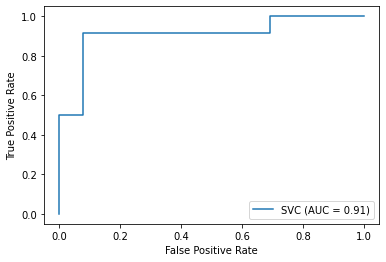

In [ ]:
import matplotlib.pyplot as plt  
from sklearn import datasets, metrics, model_selection, svm
X, y = datasets.make_classification(random_state=0)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y, random_state=0)
clf = svm.SVC(random_state=0)
clf.fit(X_train, y_train)
SVC(random_state=0)
metrics.plot_roc_curve(clf, X_val, y_val)  
plt.show()        

The ROC curve gives in a score of 0.91, which concludes that the classifier used for this model is the most effecient one. 

# Conclusion

From the above problem solution it can be concluded that the SVM model is an appropriate fit for the given data set with the accuracy 0.08 . The validation accuracy is low compard to the trainig accuracy. The accuracy of this model can be increased if the number of audio files taken under consideration are increased. The accuracy of the solution also drops when the number of features taken into account are altered (i.e if they are reduced).